In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import time
import datetime
import pickle
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torcheval.metrics import R2Score

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_pickle('/home/rouse_ai/nha/KLTN/ratings.pickle')

In [4]:
# df['rating'] = df['rating'].map(lambda x: 0 if x<4 else 1)
df['rating'] = df['rating'] - 3

In [5]:
df

,userIDX,movieIDX,rating
0,0,1176,2
1,0,655,0
2,0,902,0
3,0,3339,1
4,0,2286,2
...,...,...,...
1000204,6039,1075,-2
1000205,6039,1078,2
1000206,6039,558,2
1000207,6039,1080,1


In [6]:
num_users = df['userIDX'].max() + 1
num_movies = df['movieIDX'].max() + 1

In [7]:
density = len(df) / (num_users * num_movies) *100
density

4.264679797998748

In [8]:
data_train, data_test = train_test_split(df.values, test_size=0.12, random_state=69)
del df

In [9]:
class MovieDataset(Dataset):

    def __init__(self, data, transform=None):
        self.ratings = data

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):

        user_id_ = self.ratings[idx, 0]
        movie_id_ = self.ratings[idx, 1]
        label_ = self.ratings[idx, -1]

        user_id_ = torch.tensor(user_id_, dtype=torch.int32)
        movie_id_ = torch.tensor(movie_id_, dtype=torch.int32)
        label_ = torch.tensor(label_, dtype=torch.float32)

        # sample = {'user_idx':user_id_, "movie_idx": movie_id_, 'label':label_}
        
        return user_id_, movie_id_, label_

In [10]:
class CustomTanh35(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.div(7, 1 + torch.exp(-0.63*x)) - 3.5
class CustomTanh3(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.div(6, 1 + torch.exp(-0.77*x)) - 3

In [11]:
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, num_factors):
        """
        Deep Factorization Machine model

        Args:
            size_vector_onehot (int): size vector onehot
            num_og_feature (int): num original features
            num_factors (int): size of latent vector
        """

        super(MatrixFactorization, self).__init__()

        self.user_embedding = nn.Embedding(num_users, num_factors)
        self.item_embedding = nn.Embedding(num_items, num_factors)
        self.user_bias_embedding = nn.Embedding(num_users, 1)
        self.item_bias_embedding = nn.Embedding(num_items, 1)
        self.global_bias = nn.Parameter(torch.randn(1))

        self.clip = CustomTanh3()
        # self.clip = nn.Tanh()


    def forward(self, user_indices, item_indices):
        """
        Args:
            user_indices (array like): batch of user indexes
            item_indices (array like): batch of item indexes

        Returns:
              feature (torch.Tensor) : (batch_size, num_factors)
        """
        user_embeddings = self.user_embedding(user_indices)
        item_embeddings = self.item_embedding(item_indices)

        user_bias = self.user_bias_embedding(user_indices)[:,0]
        item_bias = self.item_bias_embedding(item_indices)[:,0]

        preds = torch.diag(torch.matmul(user_embeddings, torch.transpose(item_embeddings, 0, 1)))
        preds = preds + user_bias + item_bias + self.global_bias
        preds = self.clip(preds)

        return preds


In [12]:
batch_size = 768
dataset_train = MovieDataset(data=data_train)
dataset_test = MovieDataset(data=data_test)
loaders = {'train': DataLoader(dataset_train, batch_size, num_workers=10, shuffle=True),
          'val': DataLoader(dataset_test, batch_size, num_workers=10, shuffle=False)}

In [15]:
num_factors=10
model = MatrixFactorization(num_users=num_users, num_items=num_movies, num_factors=num_factors)
model = model.to(DEVICE)

In [16]:
def lr_base_on_epoch(epoch:int):
    if epoch <=5:
        gamma = 0.11
    elif epoch <=15:
        gamma = 0.05
    elif epoch <=25:
        gamma = 0.01
    elif epoch <=35:
        gamma = 0.001
    else:
        gamma = 0.0005
    return gamma

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1)
lambda_function = lambda epoch: lr_base_on_epoch(epoch=epoch)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_function)
metric = R2Score()

In [17]:
# model.load_state_dict(torch.load('MF{num_factors}.pth'))
# best_val_loss = pickle.load(open('best_val_loss.pkl', 'rb'))
best_val_loss = 9999

In [17]:
model.load_state_dict(torch.load(f'MF{num_factors}.pth'))
best_val_loss = 0.8743

In [1]:
logs = []
first_epoch = True
for epoch in range(40):
    current_log = {'epoch': epoch, 'loss_train': 0., 'loss_val': 0., 'val_R2_score':0., 'lr': optimizer.param_groups[0]["lr"]}
    start_time = time.time()
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        for sample_batched in loaders[phase]:
            optimizer.zero_grad()

            user_indices, movie_indices, label = sample_batched
            user_indices = user_indices.to(DEVICE)
            movie_indices = movie_indices.to(DEVICE)
            label = label.type(torch.float32).to(DEVICE)
            pred = model(user_indices, movie_indices)  
            loss = criterion(pred, label)

            current_log[f"loss_{phase}"] += loss.item() * batch_size
            with torch.set_grad_enabled(phase == 'train'):
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            if phase == 'val':
                metric.update(pred, label)
        current_log[f"loss_{phase}"] /= len(loaders[phase].dataset)
    current_log['val_R2_score'] = metric.compute().item()
    scheduler.step()
    
    if current_log['loss_val'] < best_val_loss:
        torch.save(model.state_dict(), f'MF{num_factors}.pth')
        best_val_loss = current_log['loss_val']
    else:
        if first_epoch==False:
            if epoch < 5:
                if (current_log['loss_val'] - best_val_loss) > 0.04:
                    model.load_state_dict(torch.load(f'MF{num_factors}.pth'))
            elif epoch < 10:
                if (current_log['loss_val'] - best_val_loss) > 0.02:
                    model.load_state_dict(torch.load(f'MF{num_factors}.pth'))
            else:
                if (current_log['loss_val'] - best_val_loss) > 0.01:
                    model.load_state_dict(torch.load(f'MF{num_factors}.pth'))

    print(f'Epoch {epoch}   train loss: {current_log["loss_train"]:.4f}  -  val loss: {current_log["loss_val"]:.4f}  -  val R2_score: {current_log["val_R2_score"]:.4f}  -  lr: {optimizer.param_groups[0]["lr"]}  -  time: {str(time.time()-start_time)}')
    logs.append(current_log)
pickle.dump(logs, open(f'logs_MF_regression{num_factors}_{str(datetime.datetime.now())}.pkl', 'wb'))

In [16]:
model.load_state_dict(torch.load(f'MF{num_factors}.pth'))

<All keys matched successfully>

In [18]:
list_pred = []
with torch.no_grad():
    for sample_batched in loaders['val']:
        user_indices, movie_indices, label = sample_batched
        user_indices = user_indices.to(DEVICE)
        movie_indices = movie_indices.to(DEVICE)
        pred = model(user_indices, movie_indices).detach().cpu().numpy().tolist()
        list_pred.extend(pred)

In [19]:
import matplotlib.pyplot as plt

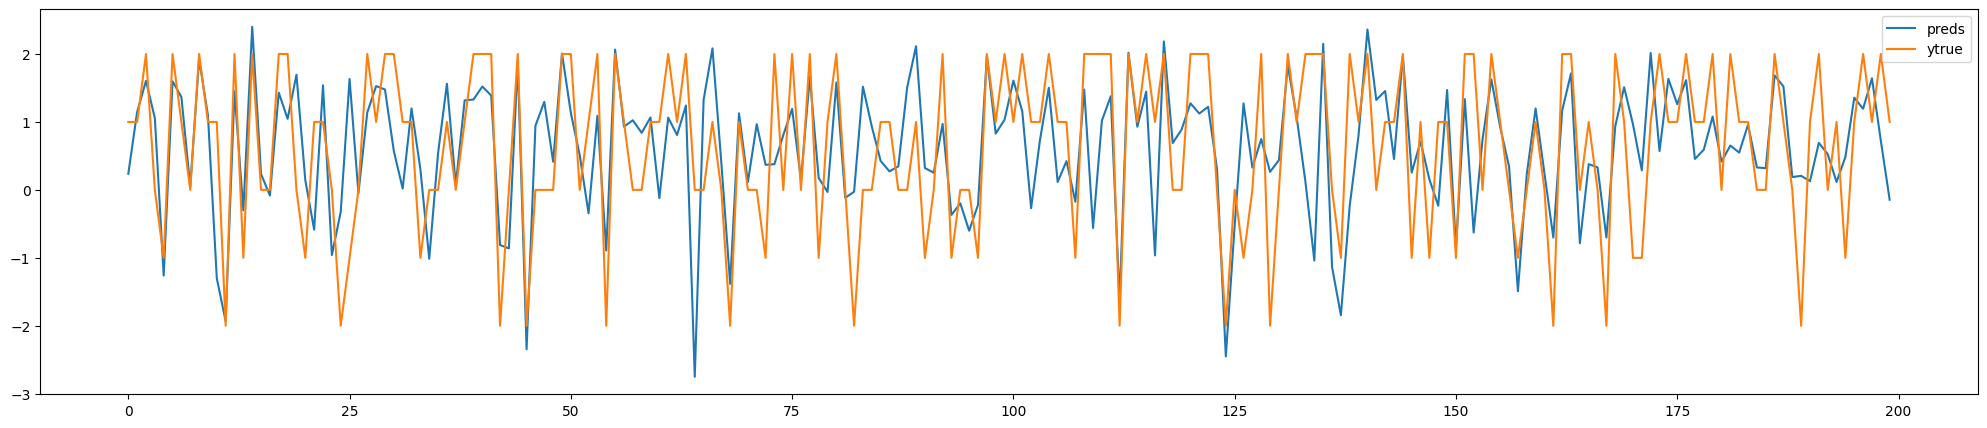

In [21]:
plt.figure(figsize=[25,5])
plt.plot(preds[200:400], label='preds')
plt.plot(ytrue[200:400], label='ytrue')

plt.legend()

In [ ]:
loss_trains = np.asarray([logs[i]['loss_train'] for i in range(len(logs))])
loss_vals = np.asarray([logs[i]['loss_val'] for i in range(len(logs))])
val_R2_scores = np.asarray([logs[i]['val_R2_score'] for i in range(len(logs))])
lrs = np.asarray([logs[i]['lr'] for i in range(len(logs))])

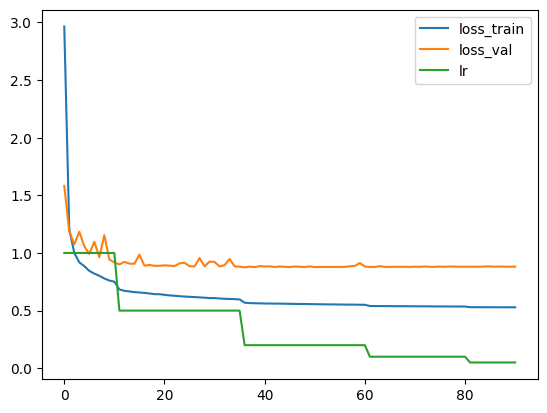

In [ ]:
plt.plot(loss_trains, label='loss_train')
plt.plot(loss_vals, label='loss_val')
plt.plot(lrs, label='lr')

plt.legend()

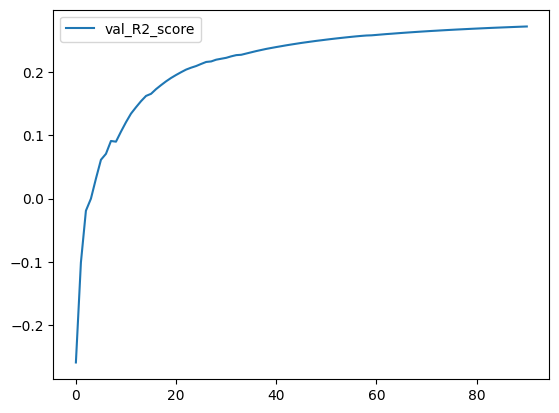

In [ ]:
plt.plot(val_R2_scores, label='val_R2_score')
plt.legend()

In [ ]:
###### mse random 3.6, r2 -0.9